# A/B-тест: новая система рекомендации постов

В данном случае, пользователи уже разделены на группы, сроки эксперимента определены, поэтому необходимо только проверить есть ли статистически значимые различие между группами.

Даты:

A/A-тест: с 23-02-2024 по 29-02-2024

A/B-тест: с 01-03-2024 по 07-03-2024

Экспермент проводился на пользователях в группах 1 и 2:
- группа 1 использовалась в качестве контроля;
- на группа 2 использован один из новых алгоритмов рекомендации постов.

**Методы анализа**

В ознакомиетльных целях проведем анализ различными способами:

- t-тест,
- Пуассоновский бутстреп,
- тест Манна-Уитни,
- t-тест на сглаженном ctr (α=5)
- t-тест и тест Манна-Уитни поверх бакетного преобразования

## 1. А/А тест

Проверим корректность системы сплитования.

Есть данные А/А-теста с 23-02-2024 по 29-02-2024. Сделаем симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации сформируем подвыборки без повторения в 500 юзеров из 1 и 2 экспериментальной группы. Проведем сравнение этих подвыборок t-testом.

**Задачи:**

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования. При выполнении задания также важно обосновать и аргументировать ваш вывод.

In [52]:
from dotenv import load_dotenv
import os

import pandas as pd
import numpy as np
import pandahouse
import hashlib
import scipy.stats as stats
from statsmodels.stats.api import CompareMeans, DescrStatsW

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Выгрузим данные

**Подключимся к clickhouse, отберем пользователей с 23-02-2024 по 29-02-2024 и посчиатаем для каждого CTR**

In [4]:
# подключаемся к clickhouse
load_dotenv()
connection = {
    'host': 'https://' + os.getenv('DB_HOST'),
    'password': os.getenv('DB_PASSWORD'),
    'user': os.getenv('DB_USER'),
    'database': os.getenv('DB_NAME')
}
# SQL запрос: отберем пользователей с '2024-02-23' по '2024-02-29' и посчиатаем для каждого CTR
q = '''
SELECT
    exp_group,
    user_id,
    SUM(action = 'like') AS likes,
    SUM(action = 'view') AS views,
    likes / views AS ctr
FROM
    {db}.feed_actions
WHERE
    toDate(time) between '2024-02-23' AND '2024-02-29'
    AND exp_group IN (1, 2)
GROUP BY
    exp_group, user_id
'''

# Отобрали пользователей
aa_test = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
# Данная выгрузка сохранена как aa_test.csv

# aa_test.to_csv('aa_test.csv', index=False)
# aa_test = pd.read_csv('aa_test.csv')

In [15]:
aa_test.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,10,34,0.294118
1,1,18392,13,56,0.232143
2,2,131473,19,98,0.193878
3,2,23985,12,44,0.272727
4,2,24523,2,10,0.200000


In [9]:
# Количество пользователей в каждой группе
aa_test.groupby('exp_group', as_index=False).count()

,exp_group,user_id,likes,views,ctr
0,1,8491,8491,8491,8491
1,2,8362,8362,8362,8362


Пользователей в каждой группе практически равное количество

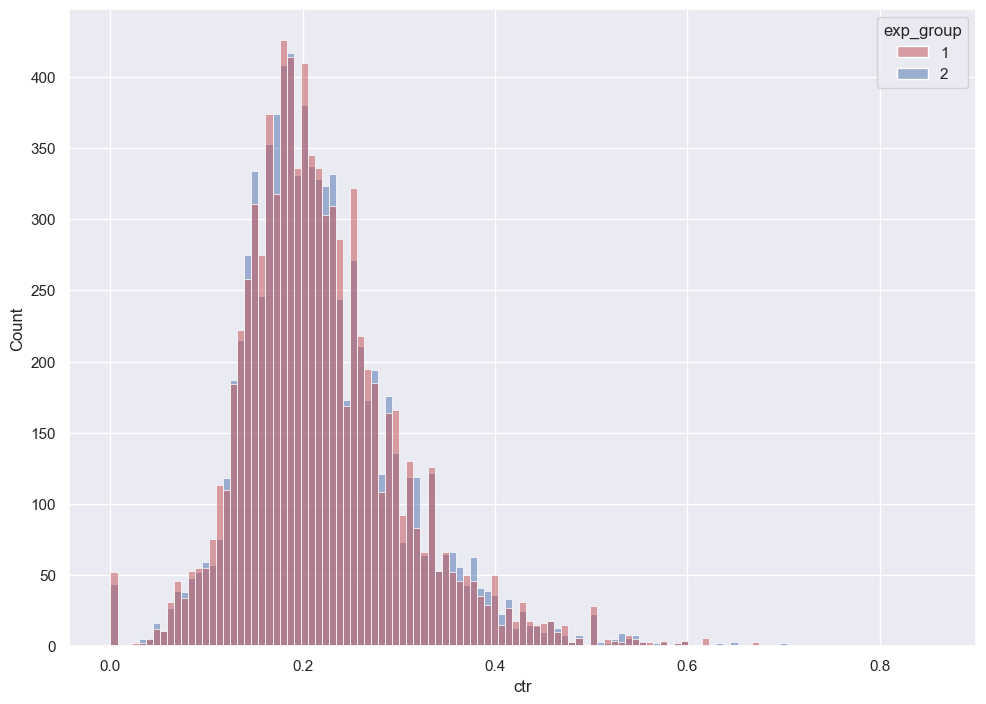

In [8]:
# Распределения CTR для каждой группы
groups = sns.histplot(data=aa_test, 
                      x='ctr', 
                      hue='exp_group', 
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Визуально группы схожи

### Симуляция АА теста

In [11]:
def simaltion_AA (ctrs_group_1, ctrs_group_2, sample_length = 500, number_of_samples = 10000):
    '''
    Функция simaltion_AA:
    Симуляция 10000 А/А-тестов. На каждой итерации формируется подвыборка без повторения в 500 юзеров из двух групп.
    Проводятся сравнения этих подвыборок t-testом.
    Выводятся:
    1. Какой процент p-values оказался меньше либо равен 0.05
    2. Гистограмма распределения получившихся 10000 p-values.
    '''

    samples_ctrs_group_1 = [ctrs_group_1.sample(sample_length).tolist() for i in range(number_of_samples)]
    samples_ctrs_group_2 = [ctrs_group_2.sample(sample_length).tolist() for i in range(number_of_samples)]
    
    p_values = stats.ttest_ind(samples_ctrs_group_1,
                               samples_ctrs_group_2,
                               equal_var=False,
                               axis=1)[1]
    
    sns.histplot(p_values)
    
    p = round((p_values[p_values <= 0.05].size / p_values.size) * 100, 2)
    
    print(f'Процент p-values меньше либо равных 0.05: {p}% \n')

Процент p-values меньше либо равных 0.05: 4.81% 



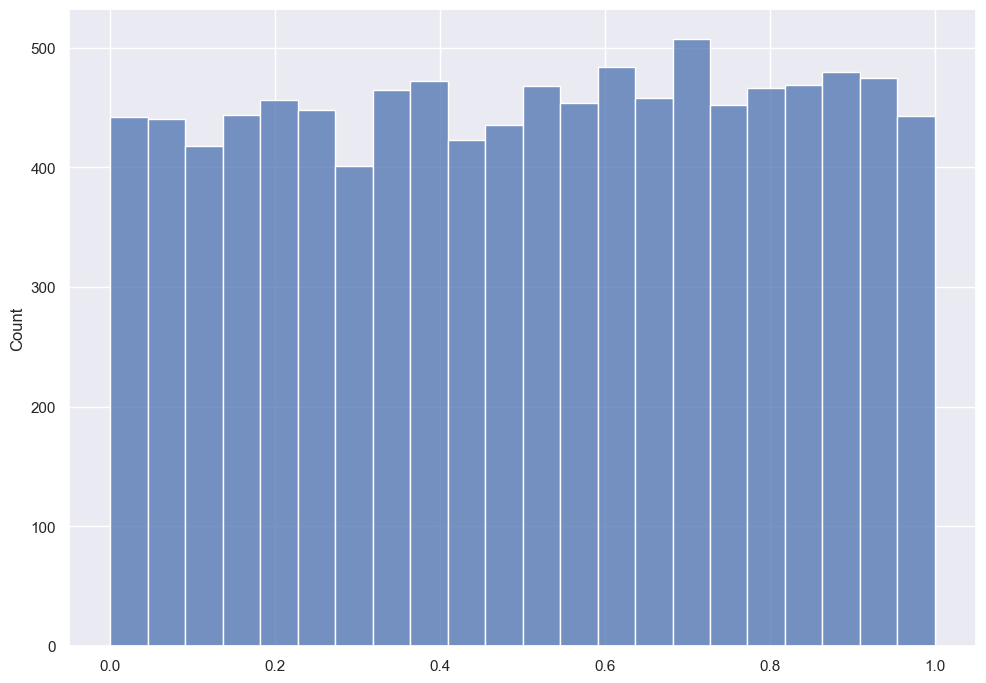

In [14]:
# Подготовим данные для функции и вызовем ее
ctrs_group_1 = aa_test.query('exp_group == 1').ctr
ctrs_group_2 = aa_test.query('exp_group == 2').ctr

simaltion_AA(ctrs_group_1, ctrs_group_2, 500, 10000)

### Вывод:

1. Согласно полученной диаграмме, распределение получившихся p-values равномерно, вероятней всего наши выборки схожи.
2. Процент p-values меньше либо равных 0.05: 4.8% (согласно последнему вызову функции). Соответственно, только в 4.82% случаев мы опровергнем нулевую гипотезу о равенстве выборок. Так как данное значение близко к p-value, веротнее всего выборки схожи.

#### Делаем вывод, что система сплитования работает корректно и можно проводить А/В тест.

## 2. А/B-тест

Проанализируем результаты эксперимента, который проводился вместе с командой дата сайентистов.

Эксперимент проходил с 01-03-2024 по 07-03-2024 включительно.

#### Выгрузим данные

Подключимся к clickhouse, отберем пользователей с 01-03-2024 по 07-03-2024 и посчиатаем для каждого CTR

In [17]:
# SQL запрос: отберем пользователей с  2024-03-01 по 2024-03-07 и посчиатаем для каждого CTR
q = '''
SELECT
    exp_group,
    user_id,
    SUM(action = 'like') AS likes,
    SUM(action = 'view') AS views,
    likes / views AS ctr
FROM
    {db}.feed_actions
WHERE
    toDate(time) between '2024-03-01' AND '2024-03-07'
    AND exp_group IN (1, 2)
GROUP BY
    exp_group, user_id
'''

# Отобрали пользователей
ab_test = pandahouse.read_clickhouse(q, connection=connection)

In [20]:
# Данная выгрузка сохранена как ab_test.csv

# ab_test.to_csv('ab_test.csv', index=False)
# ab_test = pd.read_csv('ab_test.csv')

In [19]:
ab_test.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


In [23]:
# Количество пользователей в каждой группе
ab_test.groupby('exp_group', as_index=False).count()

,exp_group,user_id,likes,views,ctr
0,1,10020,10020,10020,10020
1,2,9877,9877,9877,9877


Пользователей в каждой группе практически равное количество

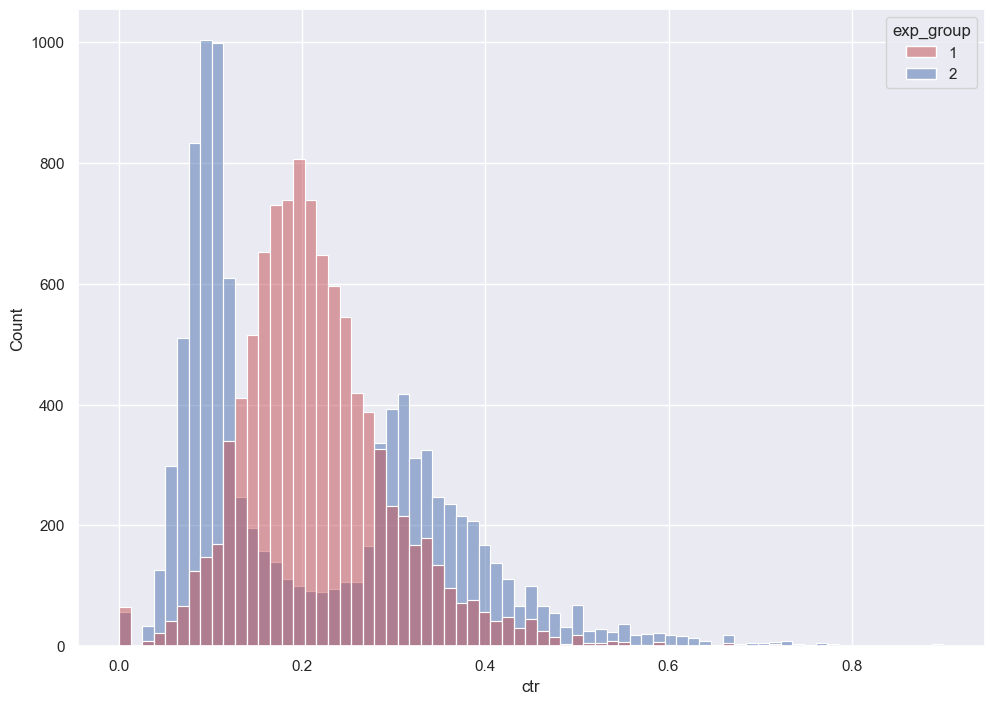

In [24]:
# Распределения CTR для каждой группы
groups = sns.histplot(data=ab_test, 
                      x='ctr', 
                      hue='exp_group', 
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Экспериментальная группа 2 имеет ненормальное распределение.

In [40]:
ab_group_1 = ab_test[ab_test.exp_group == 1]
ab_group_2 = ab_test[ab_test.exp_group == 2]

In [42]:
ab_group_1['ctr'].describe().to_frame()

,ctr
count,10020.000000
mean,0.216774
std,0.082969
min,0.000000
25%,0.163636
50%,0.205882
75%,0.257870
max,0.722222


In [43]:
ab_group_2['ctr'].describe().to_frame()

,ctr
count,9877.000000
mean,0.216102
std,0.142870
min,0.000000
25%,0.096774
50%,0.153285
75%,0.323529
max,0.900000


Несмотря на различные распределения, средние значения различаются слабо. 2 группа имеет бОльшую диспресию (бОльшая изменичвость данных). Также во второй выборке меньше медиана.

#### Предварительые выводы по методам анализа для сравнения CTR в двух группах

t-тест выглядит не лучшим вариантом, т.к. средние у нас значительно не различаются, дисперсия в выборках различна, распределение второй группы бимодально.

t-тест на сглаженном ctr (α=5) вряд ли особо исправить ситуацию с распределением.

Тест Манна-Уитни, если и прокрасится, то сложно будет интерпретировать результат. Насколько я понимаю, он показывает различие в распределениях, если распределения схожи, то смещение.

Так как распределения в двух выобрках разные, бутстреп выглядит наиболее подходящим вариантов, т.к. на выходе мы получим два нормальных распределения средних ctr. По тем же соображениям можно использовать бакетное преобразование.

### 2.1 t-тест

***H0***: средний CTR в группах 1 и 2 не изменился: CTR(1) = CTR(2)

***H1***: средний CTR в группе 2 выше, чем в группе 1: CTR(1) < CTR(2)

Для односторонней гипотезы α = 0.025

In [142]:
# Односторонняя гипотеза
stats.ttest_ind(ab_group_2.ctr,
                ab_group_1.ctr,
                equal_var=False,
                alternative='greater')

TtestResult(statistic=-0.4051491913112757, pvalue=0.6573133344296245, df=15811.22649797086)

p-value > 0.025, причем значительно, соответстветно, оставляем нулевую гипотезу. Если построить нормальные распределения, используя параметры наших выборок, можно увидеть, почему t-тест не видит различий.

In [144]:
# Доверительный интервал
cm = CompareMeans(DescrStatsW(ab_group_2.ctr), DescrStatsW(ab_group_1.ctr))
print(cm.tconfint_diff(usevar='unequal'))

(-0.003924919126775034, 0.002580309534194663)


**Симуляция двух нормальных распределений с характеристиками групп 1 и 2**

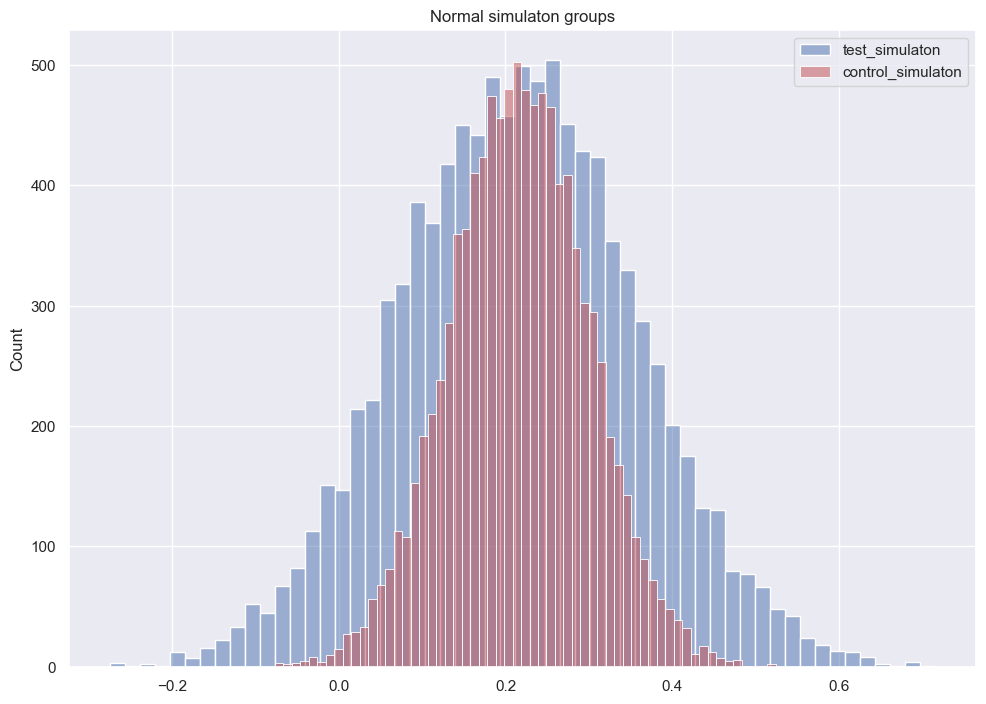

In [53]:
# контрольная группа: mean = 0.216774, std = 0.082969
normal_simulaton_control = np.random.normal(ab_group_1.ctr.mean(),
                                            ab_group_1.ctr.std(),
                                            ab_group_1.ctr.size)
# тестовая группа: mean = 0.216102, std = 0.142870
normal_simulaton_test = np.random.normal(ab_group_2.ctr.mean(),
                                         ab_group_2.ctr.std(),
                                         ab_group_2.ctr.size)
fig, ax = plt.subplots()
sns.histplot(normal_simulaton_test, label='test_simulaton', ax=ax, color='b', alpha=0.5)
sns.histplot(normal_simulaton_control, label='control_simulaton', ax=ax, color='r', alpha=0.5)
ax.legend(loc=0)
ax.title.set_text('Normal simulaton groups')
plt.show()

Визуально распределения схожи, видны различия дисперсии. Однако, данные распределения не имеют ничего общего с реальными. Опираться на t-тест в данном случае не стоит.

### 2.2 Тест Манна-Уитни

***H0***: распределения CTR в группах 1 и 2 не различаются.

***H1***: распределения CTR в группах 1 и 2 различаются.

In [55]:
print(stats.mannwhitneyu(ab_group_1.ctr,
                         ab_group_2.ctr))

A_gt_B = 0
for _ in range(10000):
    A_gt_B += ab_group_1.ctr.sample().values[0] > ab_group_2.ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)
В 56.05 % случаев A > B


p-value < 0.05, причем значительно, принимаем альтернативную гипотезу. В данном случае, сложно говорить о различии средних или медиан, т.к. это не является нулевой гипотезой для данного теста.

Тест Манна-Уитни хорошо работает, если распределения схожи, при этом не важна их форма, в таком случае, можно было бы судить о сдвиге одного распределения относительно другого. В нашем случае, это условие не соблюдается.

### 2.3 t-тест на сглаженном ctr (α=5)

***H0***: средний CTR в группах 1 и 2 не изменился: CTR(1) = CTR(2)

***H1***: средний CTR в группе 2 выше, чем в группе 1: CTR(1) < CTR(2)

Для односторонней гипотезы α = 0.025

In [60]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    '''
    Функция рассчитывает сглаженный CTR
    '''
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [77]:
# Рассчитываем общегрупповой CTR:
global_ctr_1 = ab_group_1.likes.sum()/ab_group_1.views.sum()
global_ctr_2 = ab_group_2.likes.sum()/ab_group_2.views.sum()

# Копируем данные:
smothed_group_1 = ab_group_1.copy()
smothed_group_2 = ab_group_2.copy()

# Считаем сглаженный ctr для каждого пользователя:
smothed_group_1['smothed_ctr'] = smothed_group_1.apply(lambda x: get_smothed_ctr(x['likes'],
                                                                                 x['views'],
                                                                                 global_ctr_1, 5),
                                                                                 axis=1)
smothed_group_2['smothed_ctr'] = smothed_group_2.apply(lambda x: get_smothed_ctr(x['likes'],
                                                                                 x['views'],
                                                                                 global_ctr_1, 5),
                                                                                 axis=1)

smothed_ctr:
count    10020.000000
mean         0.215280
std          0.069918
min          0.029943
25%          0.167667
50%          0.206353
75%          0.252001
max          0.623289
Name: smothed_ctr, dtype: float64

ctr
count    10020.000000
mean         0.216774
std          0.082969
min          0.000000
25%          0.163636
50%          0.205882
75%          0.257870
max          0.722222
Name: ctr, dtype: float64


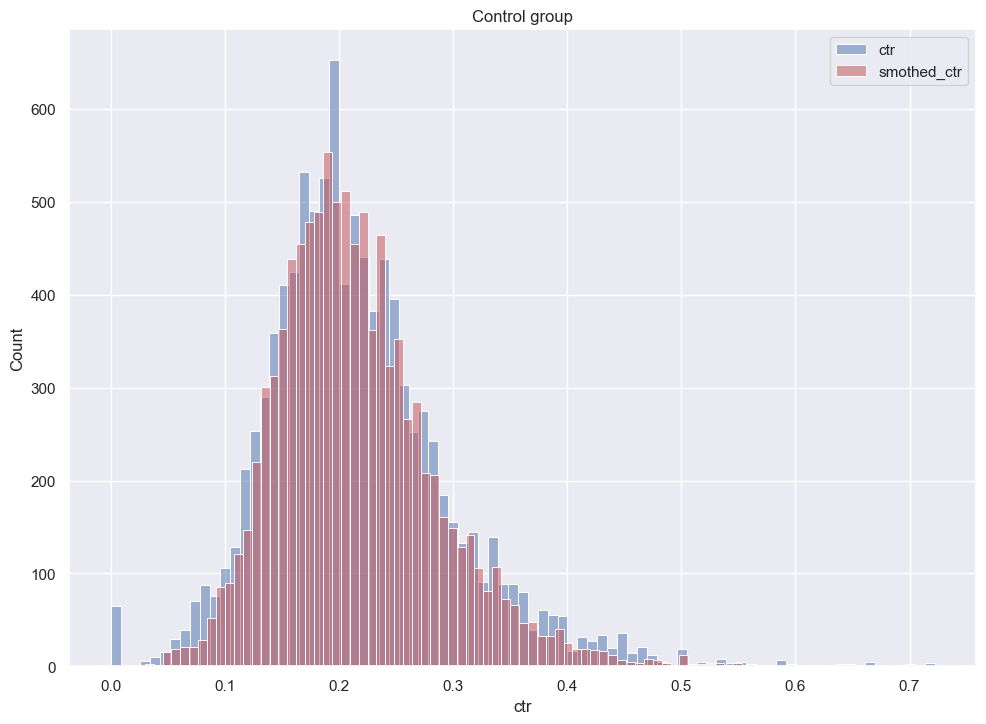

In [95]:
# Контрольная группа
print(f'smothed_ctr:\n{smothed_group_1.smothed_ctr.describe()}\n\nctr\n{smothed_group_1.ctr.describe()}')

fig, ax = plt.subplots()
sns.histplot(smothed_group_1.ctr,
             label='ctr',
             ax=ax,
             color='b',
             alpha=0.5)
sns.histplot(smothed_group_1.smothed_ctr,
             label='smothed_ctr',
             ax=ax,
             color='r',
             alpha=0.5)
ax.legend(loc=0)
ax.title.set_text('Control group')
plt.show()

smothed_ctr:
count    9877.000000
mean        0.213506
std         0.123474
min         0.032751
25%         0.107791
50%         0.160116
75%         0.311386
max         0.768267
Name: smothed_ctr, dtype: float64

ctr
count    9877.000000
mean        0.216102
std         0.142870
min         0.000000
25%         0.096774
50%         0.153285
75%         0.323529
max         0.900000
Name: ctr, dtype: float64


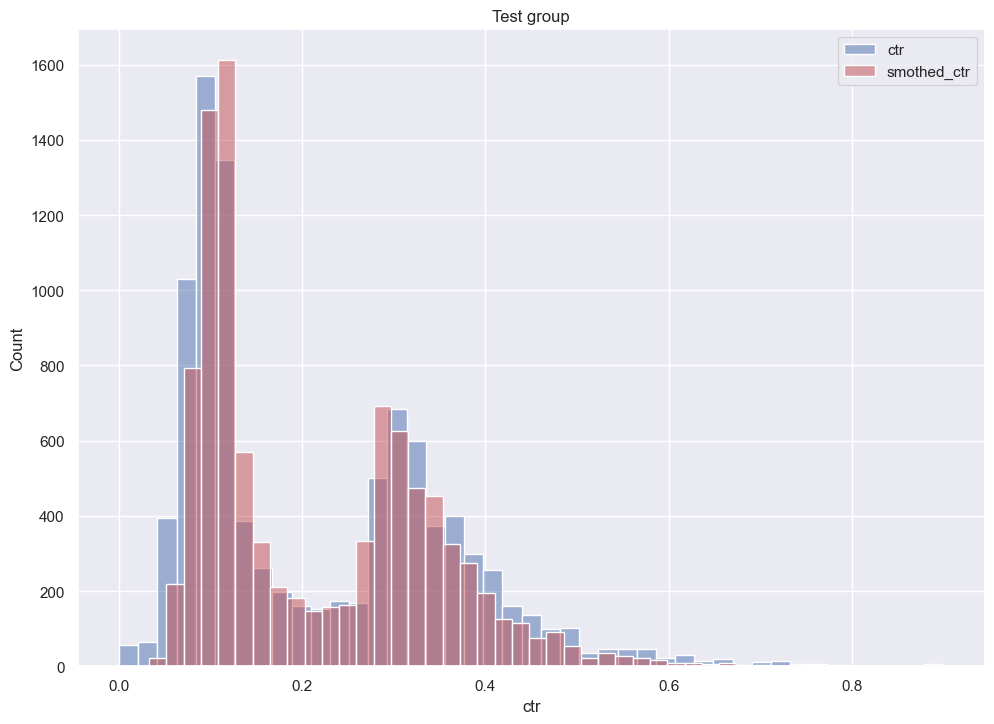

In [103]:
# Тестовая группа
print(f'smothed_ctr:\n{smothed_group_2.smothed_ctr.describe()}\n\nctr\n{smothed_group_2.ctr.describe()}')

fig, ax = plt.subplots()
sns.histplot(smothed_group_2.ctr,
             label='ctr',
             ax=ax,
             color='b',
             alpha=0.5)
sns.histplot(smothed_group_2.smothed_ctr,
             label='smothed_ctr',
             ax=ax,
             color='r',
             alpha=0.5)
ax.legend(loc=0)
ax.title.set_text('Test group')
plt.show()

Мы получили схожие данные с меньшей дисперсией.

In [145]:
# Односторонняя гипотеза
stats.ttest_ind(smothed_group_2.smothed_ctr,
                smothed_group_1.smothed_ctr,
                equal_var=False,
                alternative='greater')

TtestResult(statistic=-1.2447034376197381, pvalue=0.8933702430424518, df=15572.176418406785)

p-value > 0.025, причем значительно, соответстветно, оставляем нулевую гипотезу. Если построить нормальные распределения, используя параметры наших выборок, можно увидеть, почему t-тест не видит различий.

In [146]:
# Доверительный интервал
cm = CompareMeans(DescrStatsW(smothed_group_2.smothed_ctr), DescrStatsW(smothed_group_1.smothed_ctr))
print(cm.tconfint_diff(usevar='unequal'))

(-0.004567777133194217, 0.0010196662872872684)


p-value > 0.025, оставляем нулевую гипотезу. При этом само значение меньше, чем при t-тесте несглаженного ctr. Применив функцию сглаживания увеличилось различие в средних ctr и уменьшилась дисперсия в каждой выборке, в этом причина меньшего значения p-value.

**Симуляция двух нормальных распределений с характеристиками сглаженных CTR для групп 1 и 2**

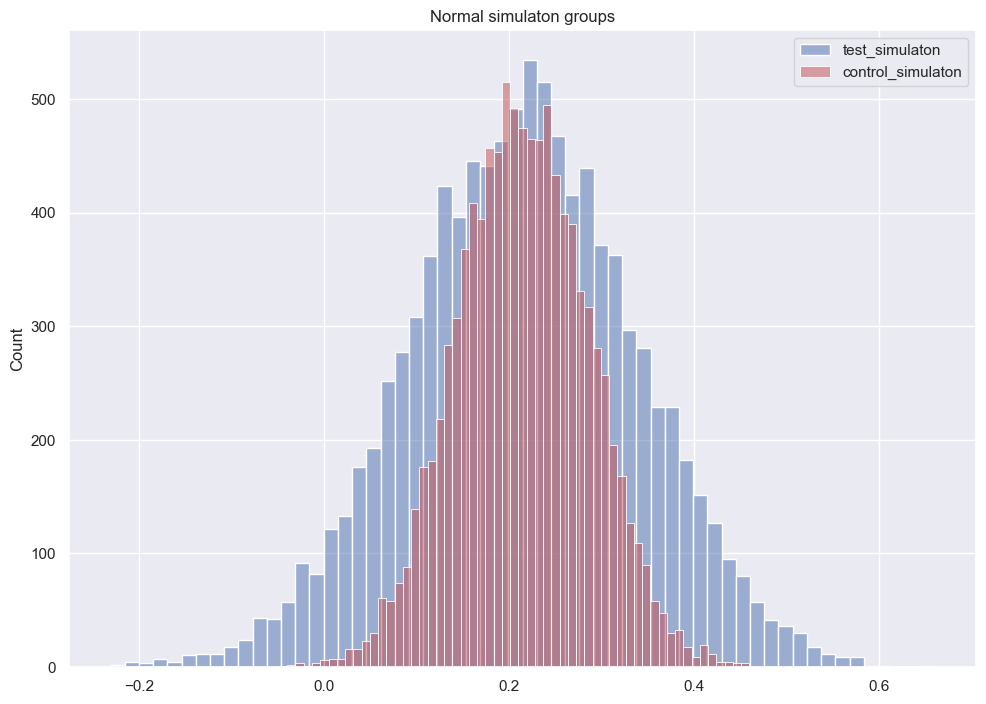

In [116]:
# контрольная группа:
normal_simulaton_control = np.random.normal(smothed_group_1.smothed_ctr.mean(),
                                            smothed_group_1.smothed_ctr.std(),
                                            smothed_group_1.smothed_ctr.size)
# тестовая группа:
normal_simulaton_test = np.random.normal(smothed_group_2.smothed_ctr.mean(),
                                         smothed_group_2.smothed_ctr.std(),
                                         smothed_group_2.smothed_ctr.size)
fig, ax = plt.subplots()
sns.histplot(normal_simulaton_test, label='test_simulaton', ax=ax, color='b', alpha=0.5)
sns.histplot(normal_simulaton_control, label='control_simulaton', ax=ax, color='r', alpha=0.5)
ax.legend(loc=0)
ax.title.set_text('Normal simulaton groups')
plt.show()

### 2.4 Пуассоновский бутстреп

***H0***: общегрупповой CTR в группах 1 и 2 не изменился: CTR_global(1) = CTR_global(2)

***H1***: общегрупповой CTR в группе 2 выше, чем в группе 1: CTR_global(1) < CTR_global(2)

Для односторонней гипотезы α = 0.025

In [118]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    '''
    Функция рассчитывает общий ctr n_bootstrap раз.
    Каждая выборка для расчета общего ctr задается согласно распределению Пуассона.
    '''
    
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

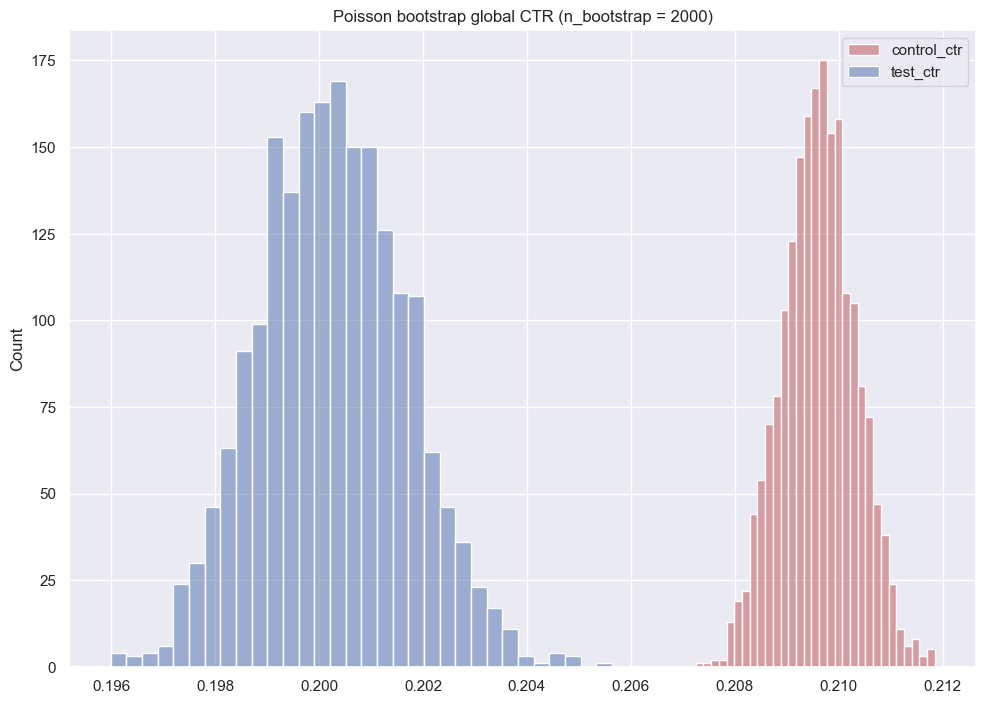

In [149]:
# Подготовим данные для функции
likes1 = ab_group_1.likes.to_numpy()
views1 = ab_group_1.views.to_numpy()
likes2 = ab_group_2.likes.to_numpy()
views2 = ab_group_2.views.to_numpy()

globalCTR1, globalCTR2 = bootstrap(likes1, views1, likes2, views2)
ctr_diff = globalCTR2 - globalCTR1

fig, ax = plt.subplots()
sns.histplot(globalCTR1,
             label='control_ctr',
             ax=ax,
             color='r',
             alpha=0.5)
sns.histplot(globalCTR2,
             label='test_ctr',
             ax=ax,
             color='b',
             alpha=0.5)

ax.legend(loc=0)
ax.title.set_text('Poisson bootstrap global CTR (n_bootstrap = 2000)')
plt.show()

In [150]:
# Проведем t-тест для полученных распределений ctr
stats.ttest_ind(globalCTR2,
                globalCTR1,
                equal_var=False,
                alternative='greater')

TtestResult(statistic=-265.2584283286938, pvalue=1.0, df=2959.9799548768965)

In [151]:
# Доверительный интервал
cm = CompareMeans(DescrStatsW(globalCTR2), DescrStatsW(globalCTR1))
print(cm.tconfint_diff(usevar='unequal'))

(-0.009417655880480389, -0.009279448614284638)


In [161]:
print(f'''p-value = 1.0, оставляем нулевую гипотезу, что CTR не изменился.
Доверительный интервал разницы CTR в двух группах: {cm.tconfint_diff(usevar='unequal')[0]}; {cm.tconfint_diff(usevar='unequal')[1]}.
Так как 0 не входит в границы и значения отрицательные, можно говорить, что произошло уменьшение CTR в тестовой группе.''')

p-value = 1.0, оставляем нулевую гипотезу, что CTR не изменился.
Доверительный интервал разницы CTR в двух группах: -0.009417655880480389; -0.009279448614284638.
Так как 0 не входит в границы и значения отрицательные, можно говорить, что произошло уменьшение CTR в тестовой группе.


### 2.5 Бакетное преобразование

In [167]:
# Посчитаем сколько пользователей попадет в каждый бакет, если количество бакетов = 50
q = '''
SELECT
    COUNT(user_id) AS bucket_users
FROM
    (SELECT
        exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM
        {db}.feed_actions
    WHERE
        toDate(time) between '2024-03-01' AND '2024-03-07'
        AND exp_group IN (1, 2)
    GROUP BY
        exp_group, bucket, user_id)
GROUP BY
    exp_group, bucket
'''

pandahouse.read_clickhouse(q, connection=connection).describe()

,bucket_users
count,100.000000
mean,198.970000
std,13.727842
min,164.000000
25%,188.750000
50%,198.500000
75%,210.000000
max,225.000000


Практически по 200 пользователей в каждом бакете

**Разделим пользователей на бакеты и посчитаем для каждого бакета ctr и медиану**

In [163]:
q = '''
SELECT
    exp_group,
    bucket,
    SUM(likes)/SUM(views) AS bucket_ctr,
    quantileExact(0.5)(ctr) AS bucket_median
FROM
    (SELECT
        exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM
        {db}.feed_actions
    WHERE
        toDate(time) between '2024-03-01' AND '2024-03-07'
        AND exp_group IN (1, 2)
    GROUP BY
        exp_group, bucket, user_id)
GROUP BY
   exp_group, bucket 
'''

ab_buckets = pandahouse.read_clickhouse(q, connection=connection)

In [165]:
# Данная выгрузка сохранена как aa_test.csv

# ab_buckets.to_csv('ab_buckets.csv', index=False)
# ab_buckets = pd.read_csv('ab_buckets.csv')

In [166]:
ab_buckets

,exp_group,bucket,bucket_ctr,bucket_median
0,1,0,0.200592,0.200000
1,2,0,0.196510,0.133333
2,1,1,0.208799,0.204545
3,2,1,0.210375,0.202703
4,1,2,0.204632,0.204819
...,...,...,...,...
95,2,47,0.196808,0.145631
96,1,48,0.216369,0.212121
97,2,48,0.194780,0.146119
98,1,49,0.206288,0.207547


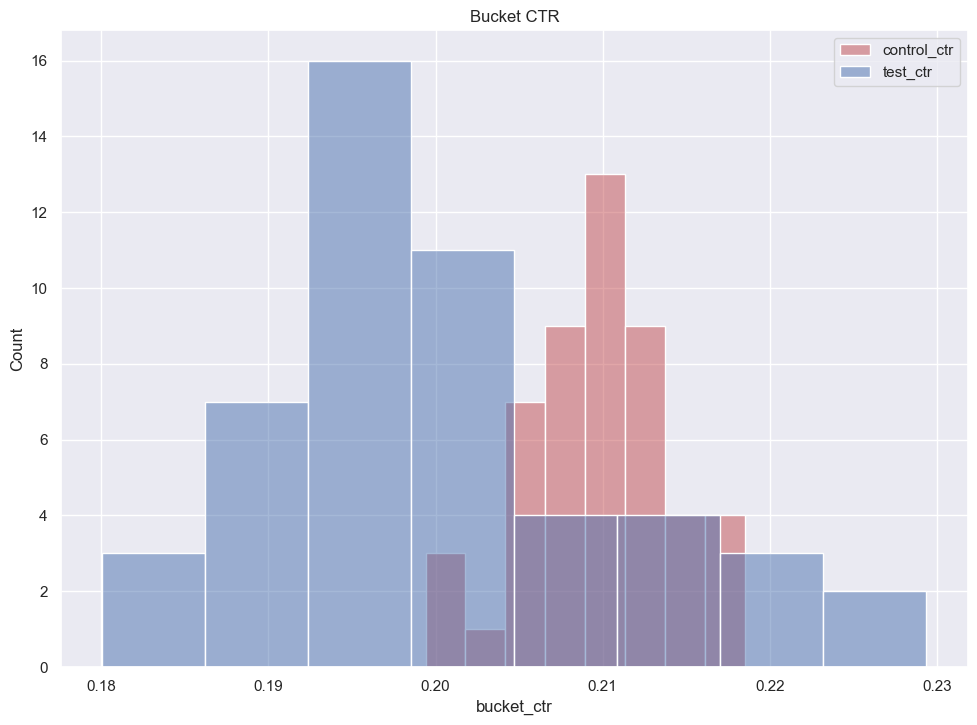

In [170]:
# Построим распределения CTR бакетов
fig, ax = plt.subplots()
sns.histplot(ab_buckets[ab_buckets.exp_group == 1].bucket_ctr,
             label='control_ctr',
             ax=ax,
             color='r',
             alpha=0.5)
sns.histplot(ab_buckets[ab_buckets.exp_group == 2].bucket_ctr,
             label='test_ctr',
             ax=ax,
             color='b',
             alpha=0.5)
ax.legend(loc=0)
ax.title.set_text('Bucket CTR')
plt.show()

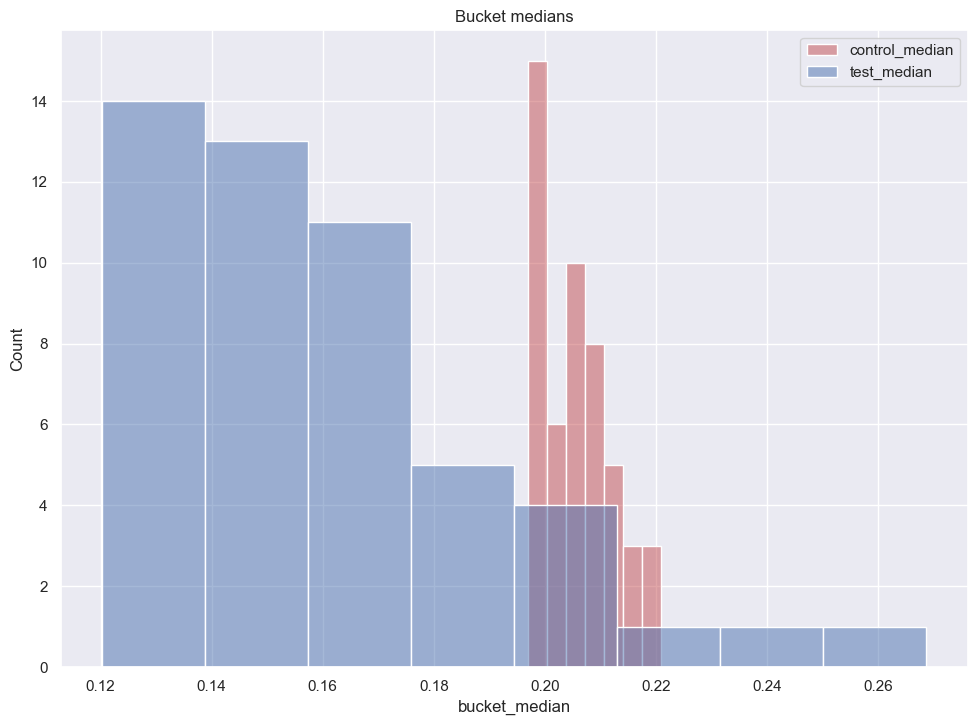

In [173]:
# Построим распределения медианы CTR бакетов
fig, ax = plt.subplots()
sns.histplot(ab_buckets[ab_buckets.exp_group == 1].bucket_median, label='control_median', ax=ax, color='r', alpha=0.5)
sns.histplot(ab_buckets[ab_buckets.exp_group == 2].bucket_median, label='test_median', ax=ax, color='b', alpha=0.5)
ax.legend(loc=0)
ax.title.set_text('Bucket medians')
plt.show()

#### 2.5.1 Проведем t-тесты и тесты Манна-Уитни для полученных распределений

**t-тест**

Для бакетных CTR:
  
- ***H0***: средний бакетный CTR в группах 1 и 2 не изменился: CTR(1) = CTR(2)
- ***H1***: средний бакетный CTR в группе 2 выше, чем в группе 1: CTR(1) < CTR(2)

Для бакетных медиан:
  
- ***H0***: средняя бакетная медиана CTR в группах 1 и 2 не изменилась: CTRmedian(1) = CTRmedian(2)
- ***H1***: средняя бакетная медиана CTR в группе 2 выше, чем в группе 1: CTRmedian(1) < CTRmedian(2)

In [178]:
# Бакетный CTR
stats.ttest_ind(ab_buckets[ab_buckets.exp_group == 2].bucket_ctr, 
                ab_buckets[ab_buckets.exp_group == 1].bucket_ctr, 
                equal_var = False,
                alternative='greater')

TtestResult(statistic=-5.614819358149381, pvalue=0.9999997703677531, df=63.82788260732127)

In [182]:
# Доверительный интервал для бакетных CTR
cm_bucket_ctr = CompareMeans(DescrStatsW(ab_buckets[ab_buckets.exp_group == 2].bucket_ctr),
                             DescrStatsW(ab_buckets[ab_buckets.exp_group == 1].bucket_ctr))
print(cm_bucket_ctr.tconfint_diff(usevar='unequal'))

(-0.012523537805654829, -0.0059502858814775225)


In [179]:
# Бакетная медиана CTR
stats.ttest_ind(ab_buckets[ab_buckets.exp_group == 2].bucket_median, 
                ab_buckets[ab_buckets.exp_group == 1].bucket_median, 
                equal_var = False,
                alternative='greater')

TtestResult(statistic=-10.286475733048839, pvalue=0.9999999999999838, df=52.82393854884867)

In [183]:
# Доверительный интервал для бакетных CTR
cm_bucket_median = CompareMeans(DescrStatsW(ab_buckets[ab_buckets.exp_group == 2].bucket_median),
                                DescrStatsW(ab_buckets[ab_buckets.exp_group == 1].bucket_median))
print(cm_bucket_median.tconfint_diff(usevar='unequal'))

(-0.054315417153246746, -0.036588756117982714)


In [184]:
print(f'''p-value близко к 1 для двух метрик, оставляем нулевую гипотезу, что CTR не изменился.

Бакетный CTR
Доверительный интервал разницы бакетных CTR в двух группах: {cm_bucket_ctr.tconfint_diff(usevar='unequal')[0]}; {cm_bucket_ctr.tconfint_diff(usevar='unequal')[1]}.
Так как 0 не входит в границы и значения отрицательные, можно говорить, что произошло уменьшение CTR в тестовой группе.

Бакетная медиана CTR
Доверительный интервал разницы бакетных медиан CTR в двух группах: {cm_bucket_median.tconfint_diff(usevar='unequal')[0]}; {cm_bucket_median.tconfint_diff(usevar='unequal')[1]}.
Так как 0 не входит в границы и значения отрицательные, можно говорить, что произошло уменьшение медианного значения CTR в тестовой группе.
''')

p-value близко к 1 для двух метрик, оставляем нулевую гипотезу, что CTR не изменился.

Бакетный CTR
Доверительный интервал разницы бакетных CTR в двух группах: -0.012523537805654829; -0.0059502858814775225.
Так как 0 не входит в границы и значения отрицательные, можно говорить, что произошло уменьшение CTR в тестовой группе.

Бакетная медиана CTR
Доверительный интервал разницы бакетных медиан CTR в двух группах: -0.054315417153246746; -0.036588756117982714.
Так как 0 не входит в границы и значения отрицательные, можно говорить, что произошло уменьшение медианного значения CTR в тестовой группе.



**Тест Манна-Уитни**

Для бакетных CTR:

- ***H0***: распределения бакетных CTR в группах 1 и 2 не различаются
- ***H1***: распределения бакетных CTR в группах 1 и 2 различаются

Для бакетных медиан:
  
- ***H0***: распределения бакетных медиан CTR в группах 1 и 2 не различаются
- ***H1***: распределения бакетных медиан CTR в группах 1 и 2 различаются

In [185]:
stats.mannwhitneyu(ab_buckets[ab_buckets.exp_group == 1].bucket_ctr, 
                   ab_buckets[ab_buckets.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [186]:
stats.mannwhitneyu(ab_buckets[ab_buckets.exp_group == 1].bucket_median, 
                   ab_buckets[ab_buckets.exp_group == 2].bucket_median, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=2315.0, pvalue=1.9249114229036693e-13)

Тесты Манна-Уитни показывают стат.значимые различия для двух метрик.

## Выводы по тестам:

a) t-тест различий не зафиксировал.  
Проблема свзяана с распределением тестовой группы и схожим средним CTR в группах.

b) Тест Манна-Уитни зафиксировал статистически значимые различия.   
При этом сложно интепретировать результаты теста, т.к. он хорошо работает, если распределения схожи, при этом не важна их форма. В таком случае, можно было бы судить о сдвиге одного распределения относительно другого. В нашем случае, это условие не соблюдается.

c) t-тест на сглаженном ctr (α=5) различий не зафиксировал.   
При этом p-value для односторонней гипотезы об увелчинии значения CTR в тестовой группе - выше, чем при t-тесте несглаженного ctr. Применив функцию сглаживания, увеличилось различие в средних ctr и снизилась дисперсия, думаю именно в этом причина увеличения значения p-value.

d) Пуассоновский бутстрап зафиксировал различия.   
0 не входит в границы доверительного интервала разницы CTR в двух группах.
Так как доверительный интервал расположен в отрицательной области, можно говорить, что произошло уменьшение CTR в тестовой группе.

e) t-тест и тест Манна-Уитни на бакетном преобразовании зафиксировали различия в ctr и медианах.   
0 не входит в границы доверительного интервала разницы бакетных CTR в двух группах.   
Так как доверительный интервал расположен в отрицательной области, можно говорить, что произошло уменьшение CTR в тестовой группе.

## Выводы по полученному распределению в тестовой группе

Если опираться на результаты тестов можно сделать вывод, что ctr в тестовой группе стал ниже.

Посмотрим распределение ctr в тестовой группе:
- Можно явно увидеть две группы пользователей:
  1. Пользоватали, у которых ctr уменьшился (по сравнению со средним в контрольной).
  2. Пользователи, у которых ctr увеличился (по сравнению со средним в контрольной).

Эти две группы явно выделяются на распределении.
Новый алгорится положительно повлиял на одну долю пользователей и негативно на другую долю пользователей, на часть пользователей влияние не оказал.

Соответственно, однозначно говорить о том. что алгоритм сделал выдачу в новостной ленте хуже нельзя.

Возможно, часть пользователей, начав пользоваться приложением в периоде А/А теста, в период А/В теста снизила свою активность и в дальнейшем перестала пользоваться приложением, т.е. пробелма не в новом алгоритме, а в том, что приложение в целом им не понравилось.

## Заключение

Думаю расскатывать новый алгоритм на всех пользователей не стоит.  
Стоит понять почему на одних пользователей алгоритм повлиял положительно, а на других отрицательно. В чем особенность и различие этих пользователей.  

Исходя из этого следует проанализировать:  
- как можно улучшить алгоритм, чтобы он работал для всех пользователей.
- выделить пользователей на которых алгоритм повлиял положительно, провести еще один тест на этом типе пользователей, если алгоритм статистически значимо увеличит значение ctr в тестовой группе, расскатить алгоритм только на схожих пользователей.